<a href="https://colab.research.google.com/github/prashantmalan/OptionPricing/blob/main/OptionPricingUsingDeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploring Options Pricing: A Fusion of Machine Learning and Financial Modeling

In the realm of financial modeling, accurately pricing options is crucial. This article delves into a sophisticated approach that combines synthetic data generation, neural networks, and Monte Carlo simulations to achieve this goal.

Synthetic Options Data Generation To simulate realistic market conditions, we begin by generating a synthetic dataset of options contracts. This involves setting parameters such as stock price, strike price, time to maturity, risk-free rate, and volatility.
Using a simplified Black-Scholes model, theoretical option prices are calculated, and noise is added to create bid and ask prices. Additional features, like 'volume' and 'open_interest,' enrich the dataset, which is organized into a Pandas DataFrame for further processing.

Neural Network Model Training The next step involves training a neural network to predict the bid price of options. The model architecture consists of several dense layers with ReLU activation functions and dropout layers for regularization. The training process employs the Adam optimizer and measures performance using mean squared error loss. Throughout the training, both the training and validation losses are monitored to ensure the model is learning effectively.

Monte Carlo Simulation and American Option Pricing For a more advanced pricing technique, the Monte Carlo simulation is employed. The `simulate_paths` function generates multiple stock price paths using geometric Brownian motion, capturing the dynamic nature of stock prices.

The Least Squares Monte Carlo (LSM) method is then applied to price American put options. This involves using linear regression to estimate the continuation value of the option and determining the optimal exercise strategy through backward induction.
Model Evaluation and Visualization To assess the model's performance, we visualize the training history with loss curves, offering insights into the learning process. A practical example of pricing an American put option using the LSM method is presented. Finally, predictions are made on a sample of the validation dataset, comparing them with actual bid prices to evaluate the model's accuracy.

Conclusion This approach showcases the power of integrating machine learning with traditional financial modeling techniques. By combining neural networks and Monte Carlo simulations, we can achieve a comprehensive and nuanced understanding of options pricing, paving the way for more accurate financial predictions.

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4687.9150 - mae: 39.3876 - val_loss: 228.3667 - val_mae: 11.4058
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 323.0771 - mae: 13.9842 - val_loss: 219.6495 - val_mae: 11.2069
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 250.8379 - mae: 12.4283 - val_loss: 226.5949 - val_mae: 11.3701
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 217.3436 - mae: 11.6782 - val_loss: 208.1133 - val_mae: 10.9437
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 198.5098 - mae: 11.3080 - val_loss: 195.5983 - val_mae: 10.6602
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 190.7670 - mae: 11.0626 - val_loss: 178.8971 - val_mae: 10.2570
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 175.1585 - mae: 10.6251 - val_loss: 187.0238 - val_mae: 10.3742
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 164.6341 - mae: 10.2688 - val_loss: 186.0369 - val_mae: 10.2436
Epoc

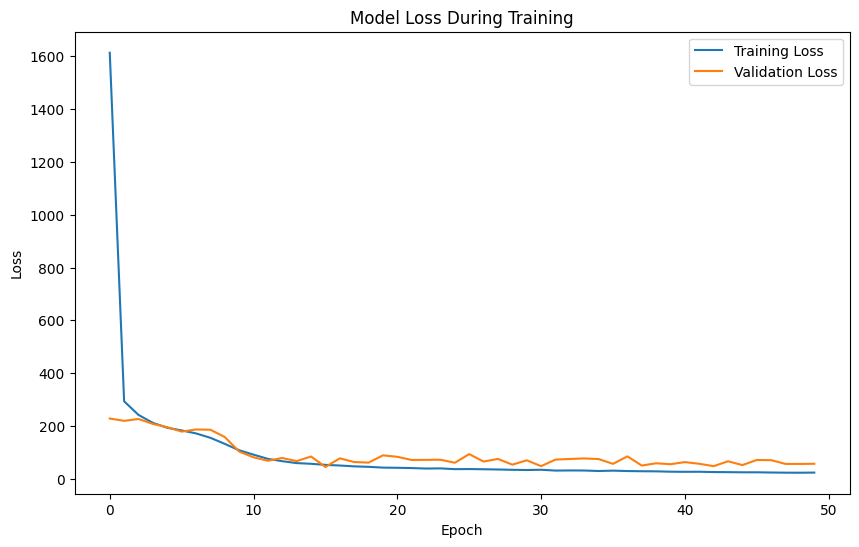


American Put Option Price: $5.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

Sample Model Predictions:
Predicted Prices: [19.892567  27.70827    3.3965595 12.763244   6.69456  ]
Actual Prices: [25.50195715 42.97074815  0.33568575 16.02584755 20.274187  ]


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import norm

# Function to generate synthetic options data
def generate_synthetic_options_data(n_samples=10000):
    # Generate random parameters
    S0 = np.random.uniform(80, 120, n_samples)  # Current stock price
    K = np.random.uniform(70, 130, n_samples)   # Strike price
    T = np.random.uniform(0.1, 2.0, n_samples)  # Time to maturity
    r = np.random.uniform(0.01, 0.05, n_samples) # Risk-free rate
    sigma = np.random.uniform(0.1, 0.5, n_samples) # Volatility

    # Generate dates
    current_date = datetime.now()
    dates = [current_date + timedelta(days=int(t*365)) for t in T]

    # Calculate theoretical option prices (using a simplified model)
    d1 = (np.log(S0/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    # Generate bid and ask prices with some noise
    theoretical_price = S0 * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    bid_price = theoretical_price * (1 - np.random.uniform(0.01, 0.03, n_samples))
    ask_price = theoretical_price * (1 + np.random.uniform(0.01, 0.03, n_samples))

    # Create DataFrame
    data = pd.DataFrame({
        'stock_price': S0,
        'strike_price': K,
        'time_to_maturity': T,
        'risk_free_rate': r,
        'volatility': sigma,
        'expiry_date': dates,
        'bid_price': bid_price,
        'ask_price': ask_price,
        'volume': np.random.randint(10, 1000, n_samples),
        'open_interest': np.random.randint(100, 5000, n_samples)
    })

    return data

# Generate synthetic data
data = generate_synthetic_options_data()

# Prepare features and target
X = data[['stock_price', 'strike_price', 'time_to_maturity',
          'risk_free_rate', 'volatility', 'volume', 'open_interest']]
y = data['bid_price']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the neural network model
# Define the neural network model
def create_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)), # Changed this line to pass a tuple
        layers.Dense(200, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(200, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(200, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(200, activation='relu'),
        layers.Dense(1)
    ])
    return model

# Create and compile the model
model = create_model(X_train.shape[1])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

# Monte Carlo simulation for path generation
def simulate_paths(S0, r, sigma, T, n_steps, n_paths):
    dt = T / n_steps
    paths = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = S0

    for t in range(1, n_steps + 1):
        Z = np.random.standard_normal(n_paths)
        paths[:, t] = paths[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt +
                                           sigma * np.sqrt(dt) * Z)
    return paths

# Least Squares Monte Carlo (LSM) method for American option pricing
def price_american_put(S0, K, T, r, sigma, n_steps, n_paths):
    # Generate paths
    dt = T / n_steps
    paths = simulate_paths(S0, r, sigma, T, n_steps, n_paths)

    # Initialize option value matrix
    option_value = np.zeros_like(paths)

    # Terminal condition
    option_value[:, -1] = np.maximum(K - paths[:, -1], 0)

    # Backward induction
    for t in range(n_steps-1, 0, -1):
        # Current stock prices
        S = paths[:, t]
        # Immediate exercise value
        exercise = np.maximum(K - S, 0)

        # In-the-money paths
        itm = exercise > 0

        if sum(itm) > 0:
            # Generate features for the regression
            X_reg = np.column_stack([
                np.ones(sum(itm)),
                S[itm],
                S[itm]**2
            ])

            # Future cash flows
            Y = option_value[itm, t+1] * np.exp(-r * dt)

            # Regression
            beta = np.linalg.lstsq(X_reg, Y, rcond=None)[0]

            # Expected continuation value
            continuation = (beta[0] + beta[1]*S[itm] + beta[2]*S[itm]**2)

            # Update option values
            option_value[itm, t] = np.where(exercise[itm] > continuation,
                                          exercise[itm],
                                          option_value[itm, t+1] * np.exp(-r * dt))

            option_value[~itm, t] = option_value[~itm, t+1] * np.exp(-r * dt)

    # Price at t=0
    return np.mean(option_value[:, 1] * np.exp(-r * dt))

# Example usage
if __name__ == "__main__":
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Test the option pricing
    test_params = {
        'S0': 100,  # Current stock price
        'K': 100,   # Strike price
        'T': 1.0,   # Time to maturity (1 year)
        'r': 0.05,  # Risk-free rate
        'sigma': 0.2, # Volatility
        'n_steps': 50,
        'n_paths': 10000
    }

    option_price = price_american_put(**test_params)
    print(f"\nAmerican Put Option Price: ${option_price:.2f}")

    # Make predictions using the trained model
    test_data = X_val.iloc[:5]
    predictions = model.predict(test_data)
    print("\nSample Model Predictions:")
    print("Predicted Prices:", predictions.flatten())
    print("Actual Prices:", y_val.iloc[:5].values)
